# Combining Datasets: Concat and Append

# 组合數據集：Concat 和 Append

> Some of the most interesting studies of data come from combining different data sources.
These operations can involve anything from very straightforward concatenation of two different datasets, to more complicated database-style joins and merges that correctly handle any overlaps between the datasets.
``Series`` and ``DataFrame``s are built with this type of operation in mind, and Pandas includes functions and methods that make this sort of data wrangling fast and straightforward.

很多對數據進行的有趣的研究都來源自不同數據源的組合。這些組合操作包括很直接的連接兩個不同的數據集，到更複雜的數據庫風格的聯表和組合可以正確的處理數據集之間的重複部分。 `Series`和`DataFrame`內建了對這些操作的支持，Pandas提供的函數和方法能夠讓這種數據操作高效而直接。

> Here we'll take a look at simple concatenation of ``Series`` and ``DataFrame``s with the ``pd.concat`` function; later we'll dive into more sophisticated in-memory merges and joins implemented in Pandas.

本節中我們會簡單介紹使用`pd.concat`函數對`Series`和`DataFrame`進行連接；然後我們深入討論Pandas中復雜的內存級別的合併及聯表操作。

In [1]:
import pandas as pd
import numpy as np

def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


> In addition, we'll create a quick class that allows us to display multiple ``DataFrame``s side by side. The code makes use of the special ``_repr_html_`` method, which IPython uses to implement its rich object display:

除此之外，我們還要創建一個類，用來將多個`DataFrame`緊靠著進行展示。下面的代碼實現了特殊的`_repr_html_`方法，IPython使用這個方法來展示對象的HTML格式：

In [2]:
class display(object):
    """多个对象的HTML格式展示"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
    

## Simple Concatenation with ``pd.concat``

## 使用`pd.concat`進行簡單連接

> Pandas has a function, ``pd.concat()``, which has a similar syntax to ``np.concatenate`` but contains a number of options that we'll discuss momentarily:

Pandas有相應的函數`pd.concat()`，與`np.concatenate`有著相似的語法，但是有一些參數我們需要深入討論：

```python
# Pandas v0.24.2的函數簽名
pd.concat(
    objs,
    axis=0,
    join='outer',
    join_axes=None,
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    sort=None,
    copy=True,
)
```

> ``pd.concat()`` can be used for a simple concatenation of ``Series`` or ``DataFrame`` objects, just as ``np.concatenate()`` can be used for simple concatenations of arrays:

`pd.concat()`可以用來對`Series`或`DataFrame`對象進行簡單的連接，就像可以用`np.concatenate()`來對數組進行簡單連接一樣：

In [3]:
ser1 = pd.Series(['A', 'B', 'C'], index=[1, 2, 3])
ser2 = pd.Series(['D', 'E', 'F'], index=[4, 5, 6])
pd.concat([ser1, ser2])

1    A
2    B
3    C
4    D
5    E
6    F
dtype: object

### Duplicate indices 重複的行索引

> One important difference between ``np.concatenate`` and ``pd.concat`` is that Pandas concatenation *preserves indices*, even if the result will have duplicate indices!
Consider this simple example:

`np.contenate`和`pd.concat`的一個重要區別是Pandas的連接會*保留行索引*，甚至在結果中包含重複索引的情況下。看下例：

In [4]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make duplicate indices!
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


> Notice the repeated indices in the result.
While this is valid within ``DataFrame``s, the outcome is often undesirable.
``pd.concat()`` gives us a few ways to handle it.

注意看到結果中的重複索引。雖然這是`DataFrame`允許的，但是結果通常不是你希望的。 `pd.concat()`提供了一些處理這個問題的方法。

#### Catching the repeats as an error 將重複的索引捕獲為錯誤

> If you'd like to simply verify that the indices in the result of ``pd.concat()`` do not overlap, you can specify the ``verify_integrity`` flag.
With this set to True, the concatenation will raise an exception if there are duplicate indices.
Here is an example, where for clarity we'll catch and print the error message:

如果你希望簡單的進行驗證`pd.concat()`結果數據集中是否含有重複的索引，你可以傳遞參數`verify_integrity=True`參數。這時連接結果的數據集中如果存在重複的行索引，將會拋出一個錯誤。下面這個例子，我們將捕獲到這個錯誤並輸出：

In [5]:
try:
    pd.concat([x, y], verify_integrity=True)
except ValueError as e:
    print("ValueError:", e)

ValueError: Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


#### Ignoring the index 忽略行索引

> Sometimes the index itself does not matter, and you would prefer it to simply be ignored.
This option can be specified using the ``ignore_index`` flag.
With this set to true, the concatenation will create a new integer index for the resulting ``Series``:

有些情況下，索引本身並不重要，那麼可以選擇忽略它們。給函數傳遞一個`ignore_index=True`的參數，`pd.concat`函數會忽略連接時的行索引，並在結果中重新創建一個整數的索引值：

In [6]:
display('x', 'y', 'pd.concat([x, y], ignore_index=True)')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


#### Adding MultiIndex keys 增加多重索引標籤

> Another option is to use the ``keys`` option to specify a label for the data sources; the result will be a hierarchically indexed series containing the data:

還有一種方法是使用`keys`參數來指定不同數據集的索引標籤；這時`pd.concat`的結果會是包含著連接數據集的多重索引數據集：

In [7]:
display('x', 'y', "pd.concat([x, y], keys=['x', 'y'])")

x
    A   B
0  A0  B0
1  A1  B1

y
    A   B
0  A2  B2
1  A3  B3

pd.concat([x, y], keys=['x', 'y'])
      A   B
x 0  A0  B0
  1  A1  B1
y 0  A2  B2
  1  A3  B3

> The result is a multiply indexed ``DataFrame``, and we can use the tools discussed in [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb) to transform this data into the representation we're interested in.

上例中的结果是一个多重索引的`DataFrame`，我们可以使用[层次化的索引](03.05-Hierarchical-Indexing.ipynb)中介绍到的方法来转换或者展示连接结果的数据。

### Concatenation with joins 使用聯表方式連接

> In the simple examples we just looked at, we were mainly concatenating ``DataFrame``s with shared column names.
In practice, data from different sources might have different sets of column names, and ``pd.concat`` offers several options in this case.
Consider the concatenation of the following two ``DataFrame``s, which have some (but not all!) columns in common:

在上面我們看到的簡單例子中，我們連接的數據集都具有相同的列及標籤。在實際情況中，從不同源得到的數據通常具有不同的列數或者列標籤，`pd.concat`提供了幾個相應的參數幫助我們完成上面的任務。下例中的兩個數據集只有部分（非全部）列和標籤相同：

In [8]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
display('df5', 'df6', 'pd.concat([df5, df6])')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6])
     A   B   C    D
1   A1  B1  C1  NaN
2   A2  B2  C2  NaN
3  NaN  B3  C3   D3
4  NaN  B4  C4   D4

> By default, the entries for which no data is available are filled with NA values.
To change this, we can specify one of several options for the ``join`` and ``join_axes`` parameters of the concatenate function.
By default, the join is a union of the input columns (``join='outer'``), but we can change this to an intersection of the columns using ``join='inner'``:

默認情況下，那些對應源數據集中不存在的元素值，將被填充為NA值。如果想改變默認行為，我們可以通過指定`join`和`join_axes`參數來實現。 `join`參數默認為`join='outer'`，就像我們上面看到的情況，結果是數據集的並集；如果將`join='inner'`傳遞給`pd.concat`，那麼就會是數據源中相同的列保留在結果中，因此結果是數據集的交集：

In [9]:
display('df5', 'df6',
        "pd.concat([df5, df6], join='inner')")

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6], join='inner')
    B   C
1  B1  C1
2  B2  C2
3  B3  C3
4  B4  C4

## Example

In [10]:
import pandas as pd
import numpy as np

ser1 = pd.Series([0, 1], index=['A', 'B'])
ser2 = pd.Series([2, 3, 4], index=['C', 'D', 'E'])
ser3 = pd.Series([5, 6], index=['F', 'G'])

pd.concat([ser1, ser2, ser3])
pd.concat([ser1, ser2, ser3], sort=True) 
pd.concat([ser1, ser2, ser3], axis=1, sort=True) 
pd.concat([ser1, ser2, ser3], axis=1, sort=True, join='inner') 

,0,1,2


In [11]:
ser4 = pd.concat([ser1, ser3]) 
pd.concat([ser1, ser4], axis=1, sort=True) 
# pd.concat([ser1, ser4], axis=1, join='inner') 
# pd.concat([ser1, ser4], axis=1, join_axes=[['A', 'B', 'F', 'G']])

,0,1
A,0.0,0
B,1.0,1
F,NaN,5
G,NaN,6


In [12]:
idc = pd.concat([ser1, ser2, ser3], axis=0, keys=['1', '2', '3'])
idc

1  A    0
   B    1
2  C    2
   D    3
   E    4
3  F    5
   G    6
dtype: int64

In [13]:
idc.unstack()

,A,B,C,D,E,F,G
1,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2.0,3.0,4.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,5.0,6.0


In [14]:
pd.concat([ser1, ser2, ser3], axis=1, keys=['1', '2', '3'], sort=True)

,1,2,3
A,0.0,NaN,NaN
B,1.0,NaN,NaN
C,NaN,2.0,NaN
D,NaN,3.0,NaN
E,NaN,4.0,NaN
F,NaN,NaN,5.0
G,NaN,NaN,6.0


In [15]:
df_li = pd.DataFrame([[10, 20], [30, 40], [50, 60]],
                      index=['a', 'c', 'e'],
                      columns=['raga', 'anuraga'])

df_ri = pd.DataFrame([[70, 80], [90, 100], [110, 120], [130, 140]],
                       index=['b', 'c', 'd', 'e'],
                       columns=['braga', 'sraga'])

pd.concat([df_li, df_ri], axis=1, keys=['one', 'two'], sort=True, join='inner') 
pd.concat([df_li, df_ri], axis=1, keys=['1', '2', '3'], sort=True, join='outer')     
pd.concat({'level1':df_li, 'level2':df_ri}, sort=True, join='outer')
pd.concat({'level1':df_li, 'level2':df_ri}, sort=True, join='outer', axis=1) 
pd.concat({'level1':df_li, 'level2':df_ri}, sort=True, join='outer', axis=1, names=['first', 'second'])

first  level1         level2       
second   raga anuraga  braga  sraga
a        10.0    20.0    NaN    NaN
b         NaN     NaN   70.0   80.0
c        30.0    40.0   90.0  100.0
d         NaN     NaN  110.0  120.0
e        50.0    60.0  130.0  140.0

In [16]:
df_li = pd.DataFrame([[10, 20], [30, 40], [50, 60]],
                      columns=['raga', 'anuraga'])

df_ri = pd.DataFrame([[70, 80], [90, 100], [110, 120], [130, 140]],
                       columns=['braga', 'sraga'])

pd.concat([df_li, df_ri], axis=0, join='outer', ignore_index=True, sort=True)
pd.concat([df_li, df_ri], axis=1, join='outer', ignore_index=True, sort=True)

,0,1,2,3
0,10.0,20.0,70,80
1,30.0,40.0,90,100
2,50.0,60.0,110,120
3,NaN,NaN,130,140


# Combining Datasets: Merge and Join
# 组合數據集：Merge 和 Join

> One essential feature offered by Pandas is its high-performance, in-memory join and merge operations.
If you have ever worked with databases, you should be familiar with this type of data interaction.
The main interface for this is the ``pd.merge`` function, and we'll see few examples of how this can work in practice.> For convenience, we will start by redefining the ``display()`` functionality from the previous section:

Pandas提供的一個基本的特性就是它的高性能、內存中進行的聯表和組合操作。如果你使用過數據庫，你應該已經很熟悉相關的數據操作了。 Pandas在這方面提供的主要接口是`pd.merge`函數，本節中我們會看到一些具體實踐的例子。為了方便我們重新定義上一節中的`display()`類，用來展示多個數據集：

In [17]:
import pandas as pd
import numpy as np

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Relational Algebra

## 關係代數

> The behavior implemented in ``pd.merge()`` is a subset of what is known as *relational algebra*, which is a formal set of rules for manipulating relational data, and forms the conceptual foundation of operations available in most databases.
The strength of the relational algebra approach is that it proposes several primitive operations, which become the building blocks of more complicated operations on any dataset.
With this lexicon of fundamental operations implemented efficiently in a database or other program, a wide range of fairly complicated composite operations can be performed.

`pd.merge()`實現的是我們稱為*關係代數*的一個子集，關係代數是一系列操作關係數據的規則的集合，它構成了大部分數據庫的數學基礎。關係代數的力量表現在它僅提出了幾個基本的運算，這些基本運算成為了更多複雜運算的組成模塊，能夠應用到任何的數據集上。只要在數據庫或者其他程序中實現了這些最基本的運算，那麼絕大部分的複雜組合運算都可以在上面實現。

> Pandas implements several of these fundamental building-blocks in the ``pd.merge()`` function and the related ``join()`` method of ``Series`` and ``Dataframe``s.
As we will see, these let you efficiently link data from different sources.

Pandas在`pd.merge()`函數中實現了一些上述所說的最基本的運算，`Series`和`DataFrame`的`join`方法也實現了這部分基本運算，你將會看到，這能讓你很高效地從不同數據源組合數據。

## Categories of Joins

## 聯表的分類

> The ``pd.merge()`` function implements a number of types of joins: the *one-to-one*, *many-to-one*, and *many-to-many* joins.
All three types of joins are accessed via an identical call to the ``pd.merge()`` interface; the type of join performed depends on the form of the input data.
Here we will show simple examples of the three types of merges, and discuss detailed options further below.

`pd.merge()`函數實現了幾種不同類型的聯表：*一對一*、*多對一*和*多對多*。所有三種類型的聯表都可以通過`pd.merge()`函數調用來實現；具體使用了哪種類型的聯表取決於輸入數據的格式。下面我們會展示一些簡單的例子來說明三種聯表類型，然後我們還會詳細的討論它們的選項。

### One-to-one joins 一對一

> Perhaps the simplest type of merge expresion is the one-to-one join, which is in many ways very similar to the column-wise concatenation seen in [Combining Datasets: Concat & Append](03.06-Concat-And-Append.ipynb).
As a concrete example, consider the following two ``DataFrames`` which contain information on several employees in a company:

也許最簡單的聯表操作類型就是一對一連接，在很多方面，這種聯表都和我們在[組合數據集：Concat 和 Append](03.06-Concat-And-Append.ipynb)中看到的按列進行數據集連接很相似。下面定義兩個`DataFrame`含有公司的一些員工信息作為一個具體的例子來說明：

In [18]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display('df1', 'df2')

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,employee,hire_date
0,Lisa,2004
1,Bob,2008
2,Jake,2012
3,Sue,2014


In [19]:
df3 = pd.merge(df1, df2)
df3

,employee,group,hire_date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


> The ``pd.merge()`` function recognizes that each ``DataFrame`` has an "employee" column, and automatically joins using this column as a key.
The result of the merge is a new ``DataFrame`` that combines the information from the two inputs.
Notice that the order of entries in each column is not necessarily maintained: in this case, the order of the "employee" column differs between ``df1`` and ``df2``, and the ``pd.merge()`` function correctly accounts for this.
Additionally, keep in mind that the merge in general discards the index, except in the special case of merges by index (see the ``left_index`` and ``right_index`` keywords, discussed momentarily).

`pd.merge()`函數會自動識別每個`DataFrame`都有"employee"列，因此會自動按照這個列作為鍵對雙方進行合併。合併的結果是一個新的`DataFrame`，其中的數據是兩個輸入數據集的聯合。再注意到每個列的排列順序在結果中並不一定保持了：在這個情況下，"employee"列的順序在`df1`和`df2`中是不同的，而`pd.merge()`函數也正確的考慮到了這點。而且，要知道的是，合併的結果通常會丟棄了原本的行索引標籤，除非在合併時制定了行索引（參見我們馬上會討論到的`left_index`和`right_index`參數）。

### Many-to-one joins 多對一

> Many-to-one joins are joins in which one of the two key columns contains duplicate entries.
For the many-to-one case, the resulting ``DataFrame`` will preserve those duplicate entries as appropriate.
Consider the following example of a many-to-one join:

多對一聯表的情況發生在兩個數據集的關鍵字列上的其中一個含有重複數據的時候。在這種多對一的情況下，結果的`DataFrame`會正確的保留那些重複的鍵值。看下面這個例子：

In [20]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
                    'supervisor': ['Carly', 'Guido', 'Steve']})
display('df3', 'df4', 'pd.merge(df3, df4)')

df3
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

df4
         group supervisor
0   Accounting      Carly
1  Engineering      Guido
2           HR      Steve

pd.merge(df3, df4)
  employee        group  hire_date supervisor
0      Bob   Accounting       2008      Carly
1     Jake  Engineering       2012      Guido
2     Lisa  Engineering       2004      Guido
3      Sue           HR       2014      Steve

> The resulting ``DataFrame`` has an aditional column with the "supervisor" information, where the information is repeated in one or more locations as required by the inputs.

結果的`DataFrame`多了一列`supervisor`，上面的數據也是按照`group`的重複情況進行重複的。

### Many-to-many joins 多對多

> Many-to-many joins are a bit confusing conceptually, but are nevertheless well defined.
If the key column in both the left and right array contains duplicates, then the result is a many-to-many merge.
This will be perhaps most clear with a concrete example.
Consider the following, where we have a ``DataFrame`` showing one or more skills associated with a particular group.
By performing a many-to-many join, we can recover the skills associated with any individual person:

多對多聯表在概念上有一點混亂，但實際上良好定義了的。如果左右的數據集在關鍵字列上都有重複數據，那麼結果就是一個多對多的組合。當然用一個具體的例子來說明是很有幫助的。比如下面的數據集`df5`存儲的是一個崗位和其對應的技能。進行了多對多聯表後，我們可以獲得每個員工對應的技能表：

In [21]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Engineering', 'Engineering', 'HR', 'HR'],
                    'skills': ['math', 'spreadsheets', 'coding', 'linux',
                               'spreadsheets', 'organization']})
display('df1', 'df5', "pd.merge(df1, df5)")

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,group,skills
0,Accounting,math
1,Accounting,spreadsheets
2,Engineering,coding
3,Engineering,linux
4,HR,spreadsheets


## merge function
Merging two datasets is the process of bringing two datasets together into one, and aligning the rows from each based on common attributes or columns. The words merge and join are used relatively interchangeably in Pandas. We have ```merge()``` function in python for joining two dataframes. 

1. **left**: use only keys from left frame, similar to a SQL left outer join; preserve key order.
2. **right**: use only keys from right frame, similar to a SQL right outer join; preserve key order.
3. **outer:** use union of keys from both frames, similar to a SQL full outer join; sort keys lexicographically.
4. **inner**: use intersection of keys from both frames, similar to a SQL inner join; preserve the order of the left keys.

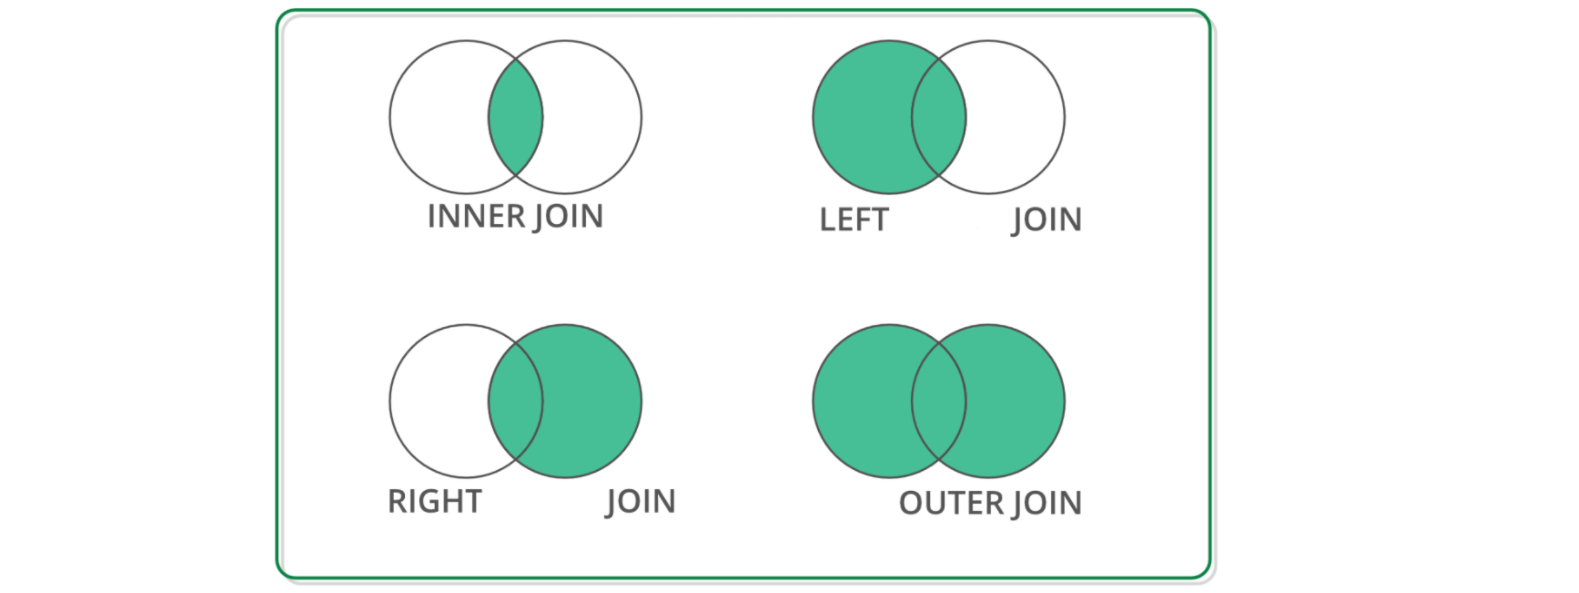


### example

In [22]:
import pandas as pd
import numpy as np
df1 = pd.DataFrame({"key": ["K0", "K1", "K2", "K3"],"A": ["A0", "A1", "A2", "A3"],"B": ["B0", "B1", "B2", "B3"]})
df2 = pd.DataFrame({'key':['K0','K1','K2','K4'],'C':['C0','C1','C2','C3'],'D':['D0','D1','D2','D3']})
df3 = pd.DataFrame({'a': ['foo', 'bar'], 'b': [1, 2]})
df4 = pd.DataFrame({'a': ['foo', 'baz'], 'c': [3, 4]})

In [23]:
# inner join
pd.merge(df1,df2, on='key',how='inner')

,key,A,B,C,D
0,K0,A0,B0,C0,D0
1,K1,A1,B1,C1,D1
2,K2,A2,B2,C2,D2


In [24]:
df3.merge(df4, how='inner', on='a')

,a,b,c
0,foo,1,3


### left join

In [25]:
pd.merge(df1,df2, on='key',how='left')

,key,A,B,C,D
0,K0,A0,B0,C0,D0
1,K1,A1,B1,C1,D1
2,K2,A2,B2,C2,D2
3,K3,A3,B3,NaN,NaN


In [26]:
df3.merge(df4, how='right', on='a')

,a,b,c
0,foo,1.0,3
1,baz,NaN,4


In [27]:
# creating 1st data frame
df1 = pd.DataFrame({'pincode':[249201,175131,263136,246171,171004], 
                   'city_name':['Rishikesh','Manali','Bhimtal', 'Rudraprayag','Shimla'],
                   'distance_from_delhi':[230,543,321, 370,343]})
# creating 2nd dataframe
df2 = pd.DataFrame({'pincode':[249201,175131,263001],
                   'district':['Dehradun','Kullu','Nainital'],
                   'State':['Uttarakhand','Himachal Pradesh','Uttarakhand']})

In [28]:
# left join
pd.merge(df1, df2, how= 'left', on='pincode')

,pincode,city_name,distance_from_delhi,district,State
0,249201,Rishikesh,230,Dehradun,Uttarakhand
1,175131,Manali,543,Kullu,Himachal Pradesh
2,263136,Bhimtal,321,NaN,NaN
3,246171,Rudraprayag,370,NaN,NaN
4,171004,Shimla,343,NaN,NaN


In [29]:
# right join
pd.merge(df1, df2, how = 'right', on = 'pincode')

,pincode,city_name,distance_from_delhi,district,State
0,249201,Rishikesh,230.0,Dehradun,Uttarakhand
1,175131,Manali,543.0,Kullu,Himachal Pradesh
2,263001,NaN,NaN,Nainital,Uttarakhand


In [30]:
# inner join
pd.merge(df1, df2, how = 'inner', on = 'pincode')

,pincode,city_name,distance_from_delhi,district,State
0,249201,Rishikesh,230,Dehradun,Uttarakhand
1,175131,Manali,543,Kullu,Himachal Pradesh


In [31]:
# outer join
pd.merge(df1, df2, how = 'outer', on = 'pincode')

,pincode,city_name,distance_from_delhi,district,State
0,249201,Rishikesh,230.0,Dehradun,Uttarakhand
1,175131,Manali,543.0,Kullu,Himachal Pradesh
2,263136,Bhimtal,321.0,NaN,NaN
3,246171,Rudraprayag,370.0,NaN,NaN
4,171004,Shimla,343.0,NaN,NaN
5,263001,NaN,NaN,Nainital,Uttarakhand


In [32]:
import pandas as pd
import numpy as np
df8 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})
df9 = pd.DataFrame({'key': ['a', 'b', 'd'],
                   'data2': range(3)})

df8.merge(df9)
pd.merge(df8, df9)
pd.merge(df8, df9, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,5,1
3,a,2,0
4,a,4,0


In [33]:
df_l = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})
df_r = pd.DataFrame({'rkey': ['a', 'b', 'd'],
                   'data2': range(3)})

print('df_l', df_l, end='\n'), print('df_r', df_r, end='\n')

pd.merge(df_l, df_r, left_on='lkey', right_on='rkey')
pd.merge(df_l, df_r,  left_on='lkey', right_on='rkey', how='outer')

df_l   lkey  data1
0    b      0
1    b      1
2    a      2
3    c      3
4    a      4
5    b      5
df_r   rkey  data2
0    a      0
1    b      1
2    d      2


,lkey,data1,rkey,data2
0,b,0.0,b,1.0
1,b,1.0,b,1.0
2,b,5.0,b,1.0
3,a,2.0,a,0.0
4,a,4.0,a,0.0
5,c,3.0,NaN,NaN
6,NaN,NaN,d,2.0


In [34]:
df_m1 = pd.DataFrame({'1key': ['b', 'b', 'a', 'c', 'a', 'b'],'data1': range(6)})
df_m2 = pd.DataFrame({'2key': ['a', 'b', 'a', 'b', 'd'],'data2': range(5)})

# let's ommit "how='outer'" or "how='inner'"
pd.merge(df_m1, df_m2, left_on='1key', right_on='2key')                  

# let's include "how='outer'" or "how='inner'"
pd.merge(df_m1, df_m2, left_on='1key', right_on='2key', how='outer')  
pd.merge(df_m1, df_m2, left_on='1key', right_on='2key', how='left')    
pd.merge(df_m1, df_m2, left_on='1key', right_on='2key', how='right')

,1key,data1,2key,data2
0,a,2.0,a,0
1,a,4.0,a,0
2,b,0.0,b,1
3,b,1.0,b,1
4,b,5.0,b,1
5,a,2.0,a,2
6,a,4.0,a,2
7,b,0.0,b,3
8,b,1.0,b,3
9,b,5.0,b,3


In [35]:
dfleft = pd.DataFrame({'key1': ['raga', 'raga', 'anuraga'],
                      'key2': ['one', 'two', 'one'],
                      'lval': [1, 2, 3]})

dfright = pd.DataFrame({'key1': ['raga', 'raga', 'anuraga', 'anuraga'],
                       'key2': ['one', 'one', 'one', 'two'],
                       'rval': [4, 5, 6, 7]})

# 'outer' includes all the values and associated data
pd.merge(dfleft, dfright, on=['key1', 'key2'], how='outer') 

# 'inner' includes only the  common values and associated data
pd.merge(dfleft, dfright, on=['key1', 'key2'], how='inner') 
pd.merge(dfleft, dfright, on=['key1', 'key2'], how='left') 
pd.merge(dfleft, dfright, on=['key1', 'key2'], how='right')
pd.merge(dfleft, dfright, on='key1')

,key1,key2_x,lval,key2_y,rval
0,raga,one,1,one,4
1,raga,one,1,one,5
2,raga,two,2,one,4
3,raga,two,2,one,5
4,anuraga,one,3,one,6
5,anuraga,one,3,two,7


In [36]:
# Merge On row
import pandas as pd
import numpy as np
dfril = pd.DataFrame({'key1': ['raga', 'raga', 'anuraga', 'raga', 'adiraga'],
                       'lval': range(5)})

dfrir = pd.DataFrame({'rval': [1, 2]},
                         index = ['raga', 'anuraga'])

pd.merge(dfril, dfrir, left_on='key1', right_index=True)
pd.merge(dfril, dfrir, left_on='key1', right_index=True, how='outer')

,key1,lval,rval
0,raga,0,1.0
1,raga,1,1.0
3,raga,3,1.0
2,anuraga,2,2.0
4,adiraga,4,NaN


In [37]:
df_l = pd.DataFrame({'key1': ['raga', 'raga', 'raga', 'anuraga', 'anuraga'],
                      'key2': [2000, 2001, 2002, 2001, 2002],
                      'data': np.arange(5.)})

df_r = pd.DataFrame(np.arange(12).reshape((6, 2)),
                       index=[['anuraga', 'anuraga', 'raga', 'raga', 'raga', 'raga'],
                              [2001, 2000, 2000, 2000, 2001, 2002]],
                       columns=['prog1', 'prog2'])

pd.merge(df_l, df_r, left_on=['key1', 'key2'], right_index=True)
pd.merge(df_l, df_r, left_on=['key1', 'key2'], right_index=True, how='outer')
pd.merge(df_l, df_r, left_on=['key1', 'key2'], right_index=True, how='left')
pd.merge(df_l, df_r, left_on=['key1', 'key2'], right_index=True, how='right')

,key1,key2,data,prog1,prog2
3,anuraga,2001,3.0,0,1
4,anuraga,2000,NaN,2,3
0,raga,2000,0.0,4,5
0,raga,2000,0.0,6,7
1,raga,2001,1.0,8,9
2,raga,2002,2.0,10,11


In [38]:
df_li = pd.DataFrame([[10, 20], [30, 40], [50, 60]],
                      index=['a', 'c', 'e'],
                      columns=['raga', 'anuraga'])

df_ri = pd.DataFrame([[70, 80], [90, 100], [110, 120], [130, 140]],
                       index=['b', 'c', 'd', 'e'],
                       columns=['braga', 'sraga'])

pd.merge(df_li, df_ri, how='outer', left_index=True, right_index=True)
pd.merge(df_li, df_ri, how='inner', left_index=True, right_index=True)

,raga,anuraga,braga,sraga
c,30,40,90,100
e,50,60,130,140


## Specifying Set Arithmetic for Joins

## 指定合併的集合算術運算

> In all the preceding examples we have glossed over one important consideration in performing a join: the type of set arithmetic used in the join.
This comes up when a value appears in one key column but not the other. Consider this example:

在上面的例子中，我們都忽略了在進行數據集合併時一個重要的內容：合併時所使用的集合算術運算類型。這部分內容對於當一個數據集的鍵值在另一個數據集中不存在時很有意義。看下例：

In [39]:
df6 = pd.DataFrame({'name': ['Peter', 'Paul', 'Mary'],
                    'food': ['fish', 'beans', 'bread']},
                   columns=['name', 'food'])
df7 = pd.DataFrame({'name': ['Mary', 'Joseph'],
                    'drink': ['wine', 'beer']},
                   columns=['name', 'drink'])
display('df6', 'df7', 'pd.merge(df6, df7)')

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7)
   name   food drink
0  Mary  bread  wine

> Here we have merged two datasets that have only a single "name" entry in common: Mary.
By default, the result contains the *intersection* of the two sets of inputs; this is what is known as an *inner join*.
We can specify this explicitly using the ``how`` keyword, which defaults to ``"inner"``:

上面我們合併的兩個數據集在關鍵字列上只有一個"name"數據是共同的：Mary。默認情況下，結果會包含兩個集合的*交集*；這被稱為*內連接*。我們顯式的指定`how`關鍵字參數，它的默認值是`"inner"`：

In [40]:
pd.merge(df6, df7, how='inner')

,name,food,drink
0,Mary,bread,wine


> Other options for the ``how`` keyword are ``'outer'``, ``'left'``, and ``'right'``.
An *outer join* returns a join over the union of the input columns, and fills in all missing values with NAs:

`how`參數的其他選項包括`'outer'`、`'left'`和`'right'`。 *外連接outer*會返回兩個集合的並集，並將缺失的數據填充為Pandas的NA值：

In [41]:
display('df6', 'df7', "pd.merge(df6, df7, how='outer')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='outer')
     name   food drink
0   Peter   fish   NaN
1    Paul  beans   NaN
2    Mary  bread  wine
3  Joseph    NaN  beer

> The *left join* and *right join* return joins over the left entries and right entries, respectively.
For example:

*左連接left*和*右連接right*返回的結果是包括所有的左邊或右邊集合。例如：

In [42]:
display('df6', 'df7', "pd.merge(df6, df7, how='left')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='left')
    name   food drink
0  Peter   fish   NaN
1   Paul  beans   NaN
2   Mary  bread  wine

> The output rows now correspond to the entries in the left input. Using
``how='right'`` works in a similar manner.All of these options can be applied straightforwardly to any of the preceding join types.

結果中的行與左集合保持一致。使用`how='right'`結果會和右集合保持一致。所有這些集合運算類型可以和前面的連接類型組合使用。

## Overlapping Column Names: The ``suffixes`` Keyword

## 列名衝突：`suffixes`關鍵字參數

> Finally, you may end up in a case where your two input ``DataFrame``s have conflicting column names.
Consider this example:

最後，你可能會碰到一種情況兩個輸入`DataFrame`有著衝突的列名。例如：

In [43]:
df8 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [1, 2, 3, 4]})
df9 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [3, 1, 4, 2]})
display('df8', 'df9', 'pd.merge(df8, df9, on="name")')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name")
   name  rank_x  rank_y
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

> Because the output would have two conflicting column names, the merge function automatically appends a suffix ``_x`` or ``_y`` to make the output columns unique.
If these defaults are inappropriate, it is possible to specify a custom suffix using the ``suffixes`` keyword:

因為結果可能會有兩個相同的列名，發生衝突，merge函數會自動為這兩個列添加`_x`和`_y`後綴，使得輸出結果每個列名稱唯一。如果默認的後綴不是你希望的，可以使用`suffixes`關鍵字參數為輸出列添加自定義的後綴：

In [44]:
display('df8', 'df9', 'pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])
   name  rank_L  rank_R
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

## Example: US States Data

## 例子：美國州數據

> Merge and join operations come up most often when combining data from different sources.
Here we will consider an example of some data about US states and their populations.
The data files can be found at http://github.com/jakevdp/data-USstates/:

合併及聯表操作在你處理多個不同數據來源時會經常出現。下面我們使用美國州及其人口數據作為例子來進行更加直觀的說明。這些數據文件可以在http://github.com/jakevdp/data-USstates/ 中找到：

In [45]:
pop = pd.read_csv('input/pd-state-population.csv')
areas = pd.read_csv('input/pd-state-areas.csv')
abbrevs = pd.read_csv('input/pd-state-abbrevs.csv')

display('pop.head()', 'areas.head()', 'abbrevs.head()')

pop.head()
  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0

areas.head()
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707

abbrevs.head()
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

> We'll start with a many-to-one merge that will give us the full state name within the population ``DataFrame``.
We want to merge based on the ``state/region``  column of ``pop``, and the ``abbreviation`` column of ``abbrevs``.
We'll use ``how='outer'`` to make sure no data is thrown away due to mismatched labels.

我們先進行一個多對一的合併，將州全名和人口數據合併在一個`DataFrame`中。我們希望合併基於`pop`數據集的`state/region`列以及`abbreviation`數據集的`abbrevs`列。使用`how='outer'`來保證合併過程中不會因為不匹配的標籤而丟失任何數據。

In [46]:
merged = pd.merge(pop, abbrevs, how='outer',
                  left_on='state/region', right_on='abbreviation')
merged = merged.drop('abbreviation', 1) # 移除冗余的列
merged.head()

/var/folders/9q/486czkcn7lv5v0hwbt71twdc0000gn/T/ipykernel_7069/3974799338.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  merged = merged.drop('abbreviation', 1) # 移除冗余的列


,state/region,ages,year,population,state
0,AL,under18,2012,1117489.0,Alabama
1,AL,total,2012,4817528.0,Alabama
2,AL,under18,2010,1130966.0,Alabama
3,AL,total,2010,4785570.0,Alabama
4,AL,under18,2011,1125763.0,Alabama


In [47]:
merged.isnull().any()  #讓我們檢查結果中是否有不匹配的情況，通過在數據集中尋找空值來查看
merged[merged['population'].isnull()].head()  #一些人口population數據是空的；再來看看是哪些。

,state/region,ages,year,population,state
2448,PR,under18,1990,NaN,NaN
2449,PR,total,1990,NaN,NaN
2450,PR,total,1991,NaN,NaN
2451,PR,under18,1991,NaN,NaN
2452,PR,total,1993,NaN,NaN


> It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.More importantly, we see also that some of the new ``state`` entries are also null, which means that there was no corresponding entry in the ``abbrevs`` key!
Let's figure out which regions lack this match:

發現所有空的人口數據都是2000年前波多黎各的；這可能因為數據來源本來就沒有這些數據造成的。更重要的是，我們發現一些新的州`state`的數據也是空的，這意味著`abbrevs`列中不存在這些州的簡稱。再看看是哪些州有這種情況：

In [48]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

> We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

從上面的結果很容易發現：人口數據集中包括波多黎各（PR）和全美國（USA）的數據，而州簡稱數據集中卻沒有這兩者數據。通過填充相應的數據可以很快解決這個問題：

In [49]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
merged.isnull().any()
final = pd.merge(merged, areas, on='state', how='left')
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


> There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:> We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

面積`area`列有空值；我們看看是哪裡出現的：結果顯示面積數據集不包括整個美國的面積。我們可以為這個空值插入正確的值（使用所有州的面積數據之和），但是這個例子中我們只需要簡單地移除空值數據即可，因為全美國的人口密度數據與我們前面的問題無關：

In [50]:
final['state'][final['area (sq. mi)'].isnull()].unique()

array(['United States'], dtype=object)

In [51]:
final.dropna(inplace=True)
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


> Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2000, and the total population.
We'll use the ``query()`` function to do this quickly (this requires the ``numexpr`` package to be installed; see [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)):

現在我們需要數據都已經準備好了。要回答前面那個問題，首先要選擇出2010年相應的部分數據集以及不分年齡的全體人口數。我們使用`query()`函數來快速完成這項任務（這需要安裝`numexpr`包，參見[高性能Pandas: ``eval()`` 和 ``query()``](03.12-Performance-Eval-and-Query.ipynb)）：

In [52]:
data2010 = final.query("year == 2010 & ages == 'total'")
data2010.head()

,state/region,ages,year,population,state,area (sq. mi)
3,AL,total,2010,4785570.0,Alabama,52423.0
91,AK,total,2010,713868.0,Alaska,656425.0
101,AZ,total,2010,6408790.0,Arizona,114006.0
189,AR,total,2010,2922280.0,Arkansas,53182.0
197,CA,total,2010,37333601.0,California,163707.0


> Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state, and then compute the result:

下面我們可以計算人口密度並排序輸出了。我們現將數據集按照`state`進行重新索引，然後計算結果：

In [53]:
data2010.set_index('state', inplace=True)
density = data2010['population'] / data2010['area (sq. mi)']
density.sort_values(ascending=False, inplace=True)
density.head()

state
District of Columbia    8898.897059
Puerto Rico             1058.665149
New Jersey              1009.253268
Rhode Island             681.339159
Connecticut              645.600649
dtype: float64

> The result is a ranking of US states plus Washington, DC, and Puerto Rico in order of their 2010 population density, in residents per square mile.
We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.

結果是美國州根據2010年人口密度的排名，包括華盛頓特區和波多黎各，數據是每平方英里的居住人數。結果顯示人口密度最稠密的地區是華盛頓特區（表中的the District of Columbia）；在其他的州中，人口密度最大的是新澤西。

In [54]:
density.tail()  #結果顯示密度最小的州 Alaska，平均每平方英里略大於1個居民。

state
South Dakota    10.583512
North Dakota     9.537565
Montana          6.736171
Wyoming          5.768079
Alaska           1.087509
dtype: float64

<!--NAVIGATION-->
< [层次化的索引](03.05-Hierarchical-Indexing.ipynb) | [目录](Index.ipynb) | [组合数据集：Merge 和 Join](03.07-Merge-and-Join.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/03.06-Concat-And-Append.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
